## Importing Libraries

In [ ]:
!pip install easyocr
!pip install promptlib
!pip install progress

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import easyocr
from PIL import Image
import glob
import promptlib
from time import sleep
from tqdm.auto import tqdm
from progress.bar import Bar
import glob
import re
from collections import OrderedDict
import string
import csv
import pandas as pd
from google.colab.patches import cv2_imshow
reader=easyocr.Reader(['en'])
import time


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def hsv_conversion(image):
    hsv_frame=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    return hsv_frame

In [ ]:
def straighten_image(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Perform edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with maximum area
    max_contour = max(contours, key=cv2.contourArea)

    # Get the minimum bounding box around the contour
    rect = cv2.minAreaRect(max_contour)

    # Calculate the aspect ratio of the bounding box
    width = rect[1][0]
    height = rect[1][1]
    aspect_ratio = max(width, height) / min(width, height)

    # Get the rotation angle from the bounding box
    angle = rect[2]
    initial_angle = angle

    # Adjust the rotation angle based on the initial angle
    if angle < -45:
        angle += 90

    if 45 < angle < 90:
        angle -= 90

    if angle == 90:
        angle -= 90

    # Rotate the image to straighten it
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    rotated_image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)


    return rotated_image


In [ ]:
def get_green_mask(hsv_frame, image):
    # Define HSV boundaries for green color masking
    low_green = np.array([50, 25, 25])
    high_green = np.array([70, 255, 255])

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Apply Canny edge detection to detect green regions
    edges = cv2.Canny(blurred_image, threshold1=30, threshold2=100)  # Adjust threshold values as needed

    # Thresholding to improve contrast
    threshold_value = 50  # Adjust threshold value as needed
    _, thresholded_image = cv2.threshold(edges, threshold_value, 255, cv2.THRESH_BINARY)

    # Create a mask from the thresholded image within the defined HSV boundaries
    mask_green = cv2.inRange(hsv_frame, low_green, high_green)

    # Bitwise AND operation to extract green regions from the original image
    green_masked_image = cv2.bitwise_and(image, image, mask=mask_green)

    return green_masked_image

In [ ]:
# def get_yellow_mask(hsv_frame,image):
#     low_yellow=np.array([25, 80, 80])     #low yellow threshold value for yellow color masking  (Can manually adjust)
#     high_yellow=np.array([40, 255, 255])  #High yellow threshold value for yellow color masking  (Can manually adjust)
#     mask_yellow=cv2.inRange(hsv_frame,low_yellow,high_yellow)
#     yellow=cv2.bitwise_and(image,image,mask=mask_yellow)
#     return yellow

In [ ]:
def get_yellow_mask(hsv_frame, image):
    # Define HSV boundaries for yellow color masking
    low_yellow = np.array([25, 80, 80])
    high_yellow = np.array([40, 255, 255])

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Apply Canny edge detection to detect yellow regions
    edges = cv2.Canny(blurred_image, threshold1=30, threshold2=100)  # Adjust threshold values as needed

    # Thresholding to improve contrast
    threshold_value = 50  # Adjust threshold value as needed
    _, thresholded_image = cv2.threshold(edges, threshold_value, 255, cv2.THRESH_BINARY)

    # Create a mask from the thresholded image within the defined HSV boundaries
    mask_yellow = cv2.inRange(hsv_frame, low_yellow, high_yellow)

    # Bitwise AND operation to extract yellow regions from the original image
    yellow_masked_image = cv2.bitwise_and(image, image, mask=mask_yellow)

    return yellow_masked_image


In [ ]:
# def get_red_mask(hsv_frame,image):
#     low_red1=np.array([0, 70, 50])        #Red threshold value for red color masking  (Can manually adjust)
#     high_red1=np.array([10, 255, 255])
#     low_red2=np.array([170, 70, 50])
#     high_red2=np.array([180, 255, 255])

#     mask_red1=cv2.inRange(hsv_frame,low_red1,high_red1)
#     mask_red2=cv2.inRange(hsv_frame,low_red2,high_red2)
#     mask_red=mask_red1|mask_red2
#     red=cv2.bitwise_and(image,image,mask=mask_red)
#     return red

In [ ]:
def get_red_mask(hsv_frame, image):
    # Define HSV boundaries for red color masking
    low_red1 = np.array([0, 70, 50])
    high_red1 = np.array([10, 255, 255])
    low_red2 = np.array([170, 70, 50])
    high_red2 = np.array([180, 255, 255])

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Apply Canny edge detection to detect red regions
    edges1 = cv2.Canny(blurred_image, threshold1=30, threshold2=100)  # Adjust threshold values as needed
    edges2 = cv2.Canny(blurred_image, threshold1=30, threshold2=100)  # Adjust threshold values as needed

    # Thresholding to improve contrast
    threshold_value = 50  # Adjust threshold value as needed
    _, thresholded_image1 = cv2.threshold(edges1, threshold_value, 255, cv2.THRESH_BINARY)
    _, thresholded_image2 = cv2.threshold(edges2, threshold_value, 255, cv2.THRESH_BINARY)

    # Create a mask from the thresholded images within the defined HSV boundaries
    mask_red1 = cv2.inRange(hsv_frame, low_red1, high_red1)
    mask_red2 = cv2.inRange(hsv_frame, low_red2, high_red2)
    mask_red = mask_red1 | mask_red2

    # Bitwise AND operation to extract red regions from the original image
    red_masked_image = cv2.bitwise_and(image, image, mask=mask_red)

    return red_masked_image

In [ ]:
# def get_white_mask(hsv_frame,image):
#     low_white=np.array([0,0,168])      #White color masking
#     high_white=np.array([172,111,255])

#     low_greyish_white = np.array([0, 0, 200])
#     high_greyish_white = np.array([180, 30, 255])

#     mask_White=cv2.inRange(hsv_frame,low_white,high_white)
#     mask_white1=cv2.inRange(hsv_frame,low_greyish_white,high_greyish_white)
#     mask_white=mask_White|mask_white1
#     white=cv2.bitwise_and(image,image,mask=mask_white)
#     return white

In [ ]:
def get_white_mask(hsv_frame, image):
    # Define HSV boundaries for white color masking
    low_white = np.array([0, 0, 168])
    high_white = np.array([172, 111, 255])

    low_greyish_white = np.array([0, 0, 200])
    high_greyish_white = np.array([180, 30, 255])

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Apply Canny edge detection to detect white regions
    edges = cv2.Canny(blurred_image, threshold1=30, threshold2=100)  # Adjust threshold values as needed

    # Thresholding to improve contrast
    threshold_value = 50  # Adjust threshold value as needed
    _, thresholded_image = cv2.threshold(edges, threshold_value, 255, cv2.THRESH_BINARY)

    # Create a mask from the thresholded image within the defined HSV boundaries
    mask = cv2.inRange(hsv_frame, low_white, high_white)
    mask1 = cv2.inRange(hsv_frame, low_greyish_white, high_greyish_white)
    mask_white = mask | mask1

    # Bitwise AND operation to extract white regions from the original image
    white_masked_image = cv2.bitwise_and(image, image, mask=mask_white)

    return white_masked_image

In [ ]:
# def get_blue_mask(hsv, frame_image):
#     lower_blue = np.array([80,50,50])
#     upper_blue = np.array([130,255,255])
#     light_blue_lower1 = np.array([90, 50, 50])
#     light_blue_upper1 = np.array([110, 255, 255])

#     mask_blue1 = cv2.inRange(hsv, lower_blue, upper_blue)
#     mask_blue2 = cv2.inRange(hsv, light_blue_lower1, light_blue_upper1)
#     mask=mask_blue1|mask_blue2
#     res = cv2.bitwise_and(frame_image,frame_image, mask= mask)
#     return res

In [ ]:
def get_blue_mask(hsv, frame_image):
    # Define HSV boundaries for blue color masking
    lower_blue = np.array([80, 50, 50])
    upper_blue = np.array([130, 255, 255])
    light_blue_lower1 = np.array([90, 50, 50])
    light_blue_upper1 = np.array([110, 255, 255])

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(frame_image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Apply Canny edge detection to detect blue regions
    edges1 = cv2.Canny(blurred_image, threshold1=30, threshold2=100)  # Adjust threshold values as needed
    edges2 = cv2.Canny(blurred_image, threshold1=30, threshold2=100)  # Adjust threshold values as needed

    # Thresholding to improve contrast
    threshold_value = 50  # Adjust threshold value as needed
    _, thresholded_image1 = cv2.threshold(edges1, threshold_value, 255, cv2.THRESH_BINARY)
    _, thresholded_image2 = cv2.threshold(edges2, threshold_value, 255, cv2.THRESH_BINARY)

    # Create a mask from the thresholded images within the defined HSV boundaries
    mask_blue1 = cv2.inRange(hsv, lower_blue, upper_blue)
    mask_blue2 = cv2.inRange(hsv, light_blue_lower1, light_blue_upper1)
    mask_blue = mask_blue1 | mask_blue2

    # Bitwise AND operation to extract blue regions from the original image
    blue_masked_image = cv2.bitwise_and(frame_image, frame_image, mask=mask_blue)

    return blue_masked_image


In [ ]:
def get_mix_strings(item):
    for ch in item:
        if not ch.isalpha():
            if not ch.isdigit():
                return False
    return True

def get_all_num(item):
    return all([ch.isdigit() for ch in item])

def get_all_alpha(item):
    return all([ch.isalpha() for ch in item])

In [ ]:
# import cv2
# import numpy as np

# def enhance_image(image):
#     # Convert the image to HSV color space
#     hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

#     # Apply bilateral filtering to reduce noise while preserving edges
#     enhanced_hsv = cv2.bilateralFilter(hsv, 15, 75, 75)  # Adjust parameters as needed

#     return enhanced_hsv



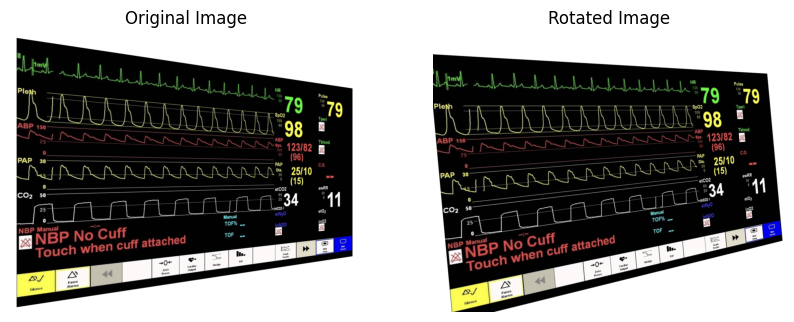

In [ ]:
image_path = '/content/gdrive/MyDrive/patient_monitors/pm_z4.jpg'
image = straighten_image(image_path)

plt.figure(figsize=(10, 5))
original_image = cv2.imread(image_path)
# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Plot the rotated image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Rotated Image')
plt.axis('off')

plt.show()

In [ ]:
# enhanced_image = enhance_image(image)
# plt.imshow(cv2.cvtColor(enhanced_image,cv2.COLOR_BGR2RGB))

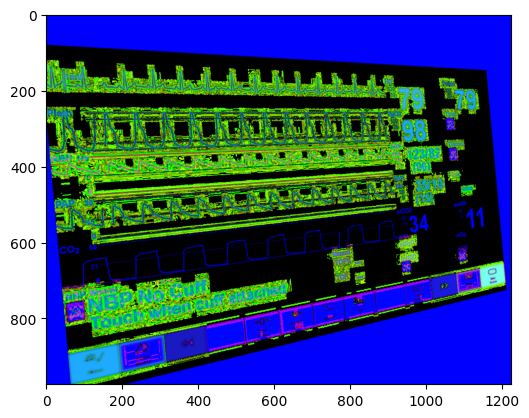

In [ ]:
hsv_frame = hsv_conversion(image)
plt.imshow(hsv_frame)

In [ ]:
def OCR_header(color):
    result = reader.readtext(color,min_size= 25,detail=0,text_threshold=0.90)  #Apply easyOCR to detect all the characters
    final_header = []
    for item in result:
        if get_all_num(item):
            continue
        elif get_mix_strings(item):
            final_header.append(item)
        elif get_all_alpha(item):
            final_header.append((item))

    return final_header

In [ ]:
arr = np.ones(image.shape)
arr[:, :, 0] = 210 # 180, 100, 175 # 210, 300, 170
arr[:, :, 1] = 300
arr[:, :, 2] = 170
arr = arr.astype(np.uint8)
arr = cv2.cvtColor(arr, cv2.COLOR_HSV2BGR)
# cv2_imshow(arr)
print(arr[0, 0])

[140 170 169]


In [ ]:
arr[0, 0]

array([140, 170, 169], dtype=uint8)

In [ ]:
def OCR_values(color):
    result = reader.readtext(color,min_size= 40,detail=0,text_threshold=0.90)
    value = [x for x in result if all(x1.isdigit() or x1 == '/' for x1 in x)]   #Select only digit values to store in a corresponding key
    return value

In [ ]:
green=get_green_mask(hsv_frame,image)
blue = get_blue_mask(hsv_frame, image)
red=get_red_mask(hsv_frame,image)
yellow=get_yellow_mask(hsv_frame,image)
white=get_white_mask(hsv_frame,image)
# purple = get_purple_mask(hsv_frame, image)
masks = [green, blue, red, yellow, white]
header_green=OCR_header(color=green)
header_red=OCR_header(color=red)
header_yellow=OCR_header(color=yellow)
header_white=OCR_header(color=white)
header_blue=OCR_header(color=blue)


In [ ]:
def get_waveform(img, threshold):
    x = []
    y = []
    for i in range(img.shape[1]):
        latest = 0
        for j in range(img.shape[0]):
            if np.any(img[j, i] > threshold):
                latest = j
        if latest != 0:
            x.append(i)
            y.append(latest)
    return x, y

In [ ]:
import math
def plot_waveform(xs, ys):
    X = np.array(xs).reshape(-1, 1)
    y = np.array(ys)
    mn = np.mean(y)
    z_scores = (y - np.mean(y)) / np.std(y)
    max_thresh = (np.max(y) - np.mean(y))/np.std(y)
    min_thresh = (abs(np.min(y) - np.mean(y)))/np.std(y)
    z_score_threshold = int(min(min_thresh, max_thresh)/2)
    # print(z_score_threshold)
    # Identify the indices of the data points that have a Z-score greater than the threshold
    outlier_indices = np.where(np.abs(z_scores) > z_score_threshold)
    indices = outlier_indices[0]
    # Remove the outliers from the data
    for i in range(len(indices)):
        left = indices[i]
        if indices[i] != 0:
            left = indices[i] - 1
        right = indices[i]
        if indices[i] != y.shape[0] - 1:
            right = indices[i] + 1
        y[indices[i]] = int((y[left] + y[right])/2)

    # plt.plot(X, y)
    # plt.show()
    return z_score_threshold, X, y

In [ ]:
def get_waveform_from_image(color):
    ret, thresh = cv2.threshold(color, 70, 255, 0)
    xs, ys = get_waveform(thresh)
    if ys.any(img[j, i] > threshold):
        max_val = max(ys)
        return xs, ys
    else:
        return None, None

In [ ]:
# for mask in masks:
#     plt.imshow(mask, cmap='gray')
#     plt.show()
#     ret, thresh = cv2.threshold(mask, 70, 255, 0)
#     x, y = get_waveform(thresh,threshold=70)
#     if x is not None and y is not None:
#         plt.scatter(x, y)
#         plt.show()


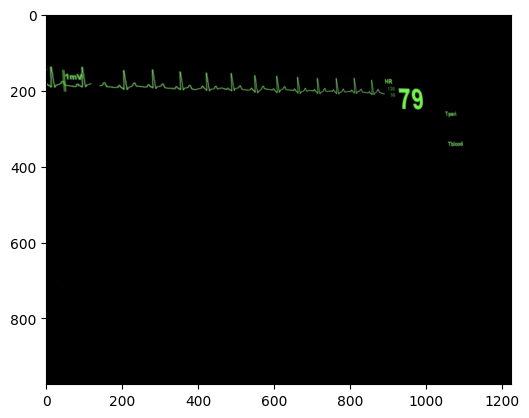

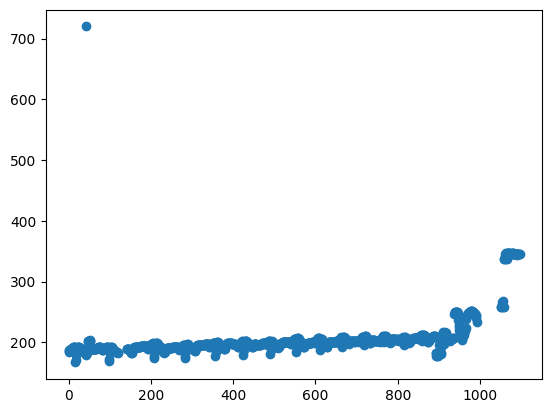

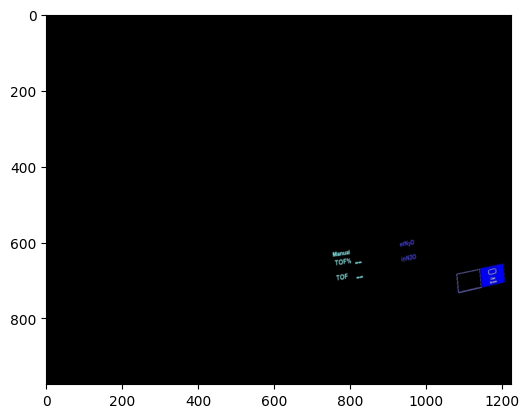

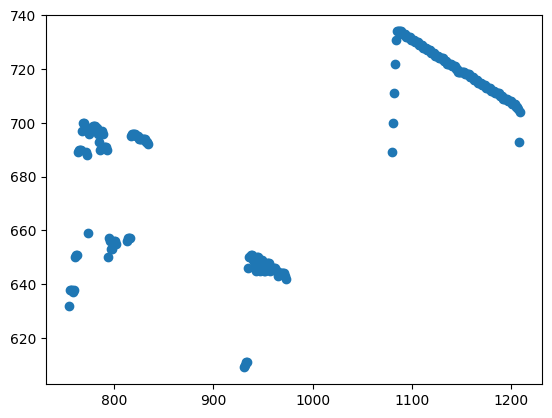

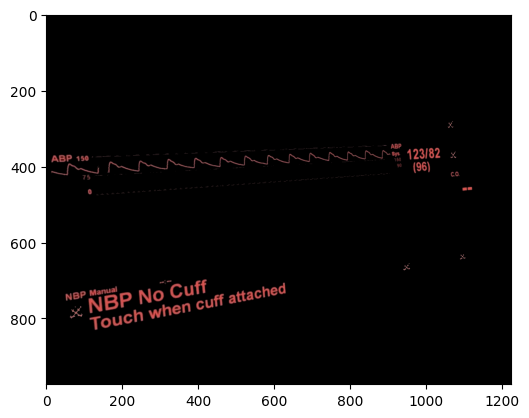

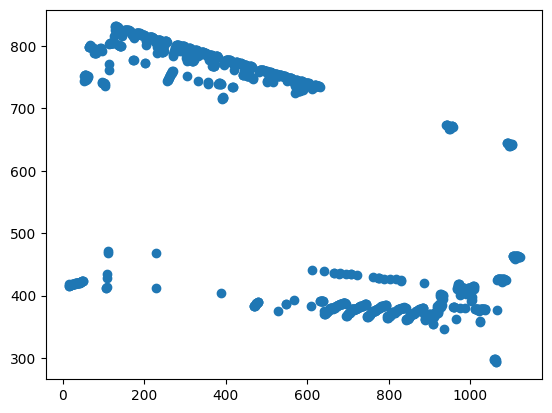

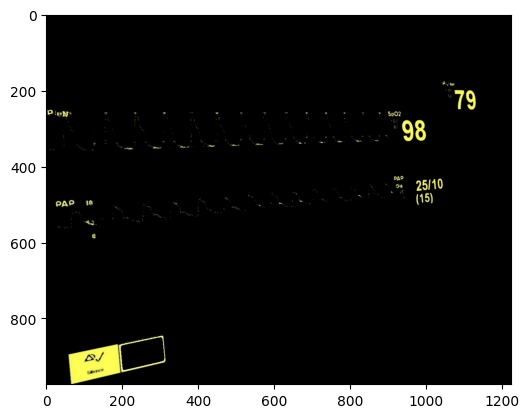

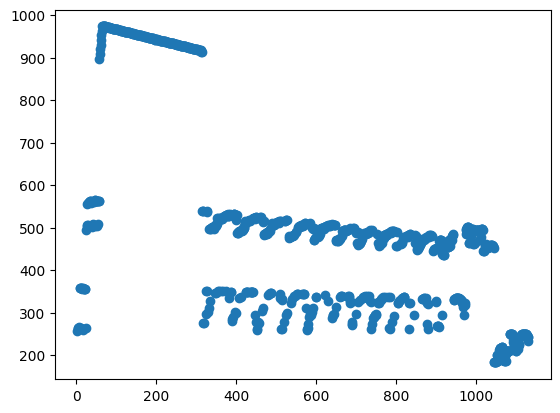

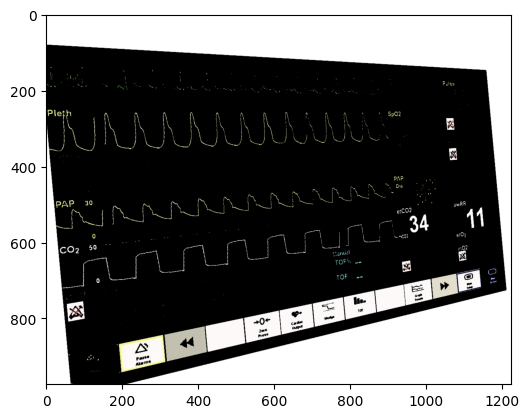

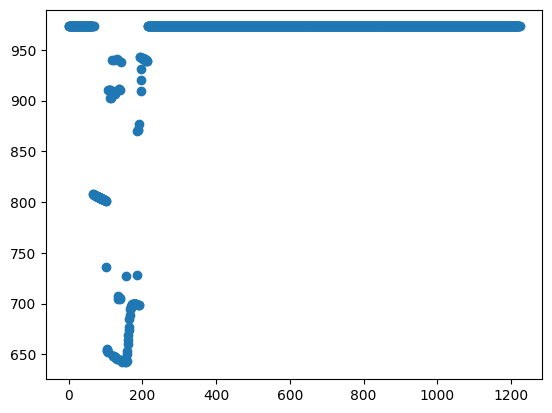

In [ ]:
for mask, color in zip(masks, ['green', 'blue', 'red', 'yellow', 'white']):
    # Invert the color channels before displaying
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    plt.imshow(mask_rgb)
    plt.show()
    ret, thresh = cv2.threshold(mask, 70, 255, 0)
    x, y = get_waveform(thresh, threshold=70)
    if x is not None and y is not None:
        plt.scatter(x, y)
        plt.show()



In [ ]:
min_color = np.array([1000, 1000, 1000])
max_color = np.array([-1, -1, -1])
for i in range(hsv_frame.shape[0]):
    for j in range(hsv_frame.shape[1]):
        if hsv_frame[i, j, 0] != 0:
            if hsv_frame[i, j, 0] < min_color[0]:
                min_color = hsv_frame[i, j]
        if hsv_frame[i, j, 0] != 0:
            if hsv_frame[i, j, 0] > max_color[0]:
                max_color = hsv_frame[i, j]
print(min_color)
print(max_color)

[  1  42 181]
[179  30 214]


In [ ]:
# plt.imshow(green)
# plt.imshow(red)
# plt.imshow(yellow)
# plt.imshow(white)
# plt.imshow(purple)
# plt.imshow(blue)

In [ ]:
print(header_green)
print(header_red)
print(header_yellow)
print(header_white)
print(header_blue)
# print(header_purple)

['Tperi', 'Tblood']
['ABP', 'No', 'Cuff', 'attached', 'Manual', 'NBP', 'NBP', 'cuff', 'when', 'Touch']
['Spoz', 'Cl', 'PAP', 'PAP']
['Plets', 'Spoz', 'PAP', 'etcoz', 'CO2', '13O2', '8i02', 'tenuJI', 'Tof']
['Manual', 'ioNzo', 'TOF']


In [ ]:
green_value=OCR_values(green)
red_value=OCR_values(red)
yellow_value=OCR_values(yellow)
white_value=OCR_values(white)
blue_value=OCR_values(blue)
# purple_value=OCR_values(purple)

In [ ]:
print(green_value)
print(red_value)
print(yellow_value)
print(white_value)
print(blue_value)
# print(purple_value)

['79']
['123/82']
['79', '98', '25/10']
['34', '11']
[]


In [ ]:
print()